In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force CPU mode
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from glob import glob
from torchvision.utils import save_image
device = torch.device("cpu")
latent_dim = 100
image_size = 64

# --------------------------
# Model Definitions
# --------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, latent_dim, 8)  # 1x1
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 8),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 8),  # 1x1
        )

    def forward(self, x):
        return self.net(x).view(-1)

# --------------------------
# Data Loaders
# --------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



In [2]:
train_dataset = ImageFolder("D:/Researchwork24-25/work7/wood/wood/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# --------------------------
# Initialize Models
# --------------------------
E = Encoder().to(device)
G = Decoder().to(device)
D = Discriminator().to(device)

optimizer_G = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=2e-4)
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()



In [4]:
# --------------------------
# Training Loop
# --------------------------
for epoch in range(40):
    E.train(); G.train(); D.train()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        z = E(imgs)
        recon = G(z)

        # --- Discriminator training ---
        D_real = D(imgs)
        D_fake = D(recon.detach())
        d_loss = -torch.mean(D_real) + torch.mean(D_fake)
        optimizer_D.zero_grad(); d_loss.backward(); optimizer_D.step()

        # --- Generator training ---
        D_fake = D(recon)
        z_fake = E(recon)
        g_loss = loss_fn(imgs, recon) + loss_fn(z, z_fake) + -torch.mean(D_fake)
        optimizer_G.zero_grad(); g_loss.backward(); optimizer_G.step()

    print(f"[Epoch {epoch+1}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
    if (epoch+1) % 10 == 0:
        save_image(recon[:25], f"Ganomaly_epoch{epoch+1}.png", normalize=True, nrow=5)



[Epoch 1] D_loss: -2.4550, G_loss: -7.1643
[Epoch 2] D_loss: -17.6791, G_loss: -0.3031
[Epoch 3] D_loss: -32.6043, G_loss: 6.3846
[Epoch 4] D_loss: -37.2448, G_loss: 2.3056
[Epoch 5] D_loss: -49.7108, G_loss: 7.3251
[Epoch 6] D_loss: -67.5257, G_loss: 15.0429
[Epoch 7] D_loss: -55.9177, G_loss: 2.4475
[Epoch 8] D_loss: -83.5362, G_loss: 25.4772
[Epoch 9] D_loss: -102.6812, G_loss: 32.1341
[Epoch 10] D_loss: -139.3051, G_loss: 46.9160
[Epoch 11] D_loss: -158.6299, G_loss: 52.2633
[Epoch 12] D_loss: -191.9474, G_loss: 72.5087
[Epoch 13] D_loss: -221.3559, G_loss: 87.3694
[Epoch 14] D_loss: -248.6318, G_loss: 100.0401
[Epoch 15] D_loss: -274.1322, G_loss: 108.0732
[Epoch 16] D_loss: -293.6129, G_loss: 113.0474
[Epoch 17] D_loss: -315.9059, G_loss: 123.3571
[Epoch 18] D_loss: -338.4099, G_loss: 132.2536
[Epoch 19] D_loss: -385.7377, G_loss: 165.6399
[Epoch 20] D_loss: -406.8440, G_loss: 165.0448
[Epoch 21] D_loss: -436.7643, G_loss: 182.5907
[Epoch 22] D_loss: -460.4532, G_loss: 190.1597
[

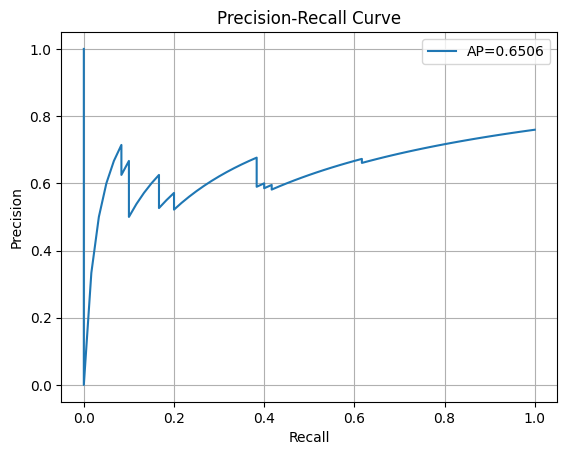

Mean Average Precision (mAP): 0.6505945446940751


In [5]:
# --------------------------
# Testing & Anomaly Scoring
# --------------------------
def compute_anomaly_score(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        z = E(img)
        recon = G(z)
        z_recon = E(recon)
        score = F.l1_loss(z, z_recon).item()
    return score

def evaluate_testset(test_folder):
    scores = []
    labels = []

    for label_name in os.listdir(test_folder):
        folder = os.path.join(test_folder, label_name)
        label = 0 if label_name.lower() == "good" else 1
        for img_file in glob(folder + "/*.png"):
            score = compute_anomaly_score(img_file)
            scores.append(score)
            labels.append(label)
    return labels, scores

y_true, y_score = evaluate_testset("wood/test")

# --------------------------
# Compute mAP and PR curve
# --------------------------
ap = average_precision_score(y_true, y_score)
precision, recall, _ = precision_recall_curve(y_true, y_score)

plt.plot(recall, precision, label=f"AP={ap:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(); plt.grid(); plt.show()
print("Mean Average Precision (mAP):", ap)

In [6]:
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import make_grid


In [7]:
def detect_defect(test_img_path):
    G.eval()

    # Load and preprocess real test image
    img = Image.open(test_img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 64, 64]

    best_score = -1
    best_z = None

    for _ in range(500):  # Try 500 latent vectors
        z = torch.randn(1, latent_dim, 1, 1, device=device)
        gen_img = G(z)  # Output: [1, 3, ?, ?]

        # Resize generated image to match test image size (e.g., 64x64)
        if gen_img.shape != img.shape:
            gen_img = torch.nn.functional.interpolate(
                gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
            )

        # Convert tensors to numpy for SSIM
        real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

        # Make sure they are the same shape for SSIM
        h = min(real_np.shape[0], fake_np.shape[0])
        w = min(real_np.shape[1], fake_np.shape[1])
        real_np = real_np[:h, :w, :]
        fake_np = fake_np[:h, :w, :]

        try:
            score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)
        except Exception as e:
            print(f"SSIM error on {test_img_path}: {e}")
            continue

        if score > best_score:
            best_score = score
            best_z = z

    best_fake = G(best_z)

    # Resize again to match before MSE
    if best_fake.shape != img.shape:
        best_fake = torch.nn.functional.interpolate(
            best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
        )

    # Compute MSE
    mse = torch.mean((img - best_fake) ** 2).item()

    # Print results
    print(f"\nImage: {test_img_path}")
    print(f"MSE: {mse:.4f}, SSIM: {best_score:.4f}")
    if mse > 0.1 or best_score < 0.6:
        print("⚠️ Defect Detected")
    else:
        print("✅ No Defect Detected")

    return img, best_fake

In [8]:
detect_defect("D:\\Researchwork24-25\\work7\\wood\\wood\\test\\hole\\000.png")


Image: D:\Researchwork24-25\work7\wood\wood\test\hole\000.png
MSE: 0.0839, SSIM: 0.0709
⚠️ Defect Detected


(tensor([[[[ 0.2471,  0.3098,  0.4118,  ...,  0.3333,  0.2235,  0.2157],
           [ 0.2863,  0.3412,  0.4510,  ...,  0.3725,  0.2706,  0.2706],
           [ 0.3412,  0.4196,  0.4902,  ...,  0.4039,  0.3020,  0.3333],
           ...,
           [ 0.4824,  0.4275,  0.3176,  ...,  0.2863,  0.2549,  0.2941],
           [ 0.4667,  0.4510,  0.3176,  ...,  0.2627,  0.2471,  0.2627],
           [ 0.4118,  0.4196,  0.3098,  ...,  0.2549,  0.2000,  0.2157]],
 
          [[-0.1373, -0.0902, -0.0353,  ..., -0.0667, -0.1529, -0.1686],
           [-0.1137, -0.0745, -0.0118,  ..., -0.0510, -0.1216, -0.1373],
           [-0.0667, -0.0196,  0.0275,  ..., -0.0275, -0.0980, -0.0745],
           ...,
           [ 0.0824,  0.0196, -0.0510,  ..., -0.0745, -0.1137, -0.0745],
           [ 0.0824,  0.0353, -0.0588,  ..., -0.0980, -0.1137, -0.0902],
           [ 0.0431,  0.0196, -0.0588,  ..., -0.1137, -0.1608, -0.1294]],
 
          [[-0.3333, -0.3098, -0.2706,  ..., -0.3020, -0.3569, -0.3804],
           [-

In [12]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

def batch_test_analysis(test_folder):
    records = []

    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        for img_file in glob.glob(os.path.join(class_path, "*.png")):
            try:
                G.eval()
                img = Image.open(img_file).convert("RGB")
                img = transform(img).unsqueeze(0).to(device)

                best_score = -1
                best_z = None

                for _ in range(200):
                    z = torch.randn(1, latent_dim, 1, 1, device=device)
                    gen_img = G(z)

                    # Resize generated image to match original if needed
                    if gen_img.shape != img.shape:
                        gen_img = torch.nn.functional.interpolate(
                            gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                        )

                    # Convert tensors to NumPy
                    real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
                    fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

                    # Ensure equal size for SSIM
                    h = min(real_np.shape[0], fake_np.shape[0])
                    w = min(real_np.shape[1], fake_np.shape[1])
                    real_np = real_np[:h, :w, :]
                    fake_np = fake_np[:h, :w, :]

                    score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)

                    if score > best_score:
                        best_score = score
                        best_z = z

                best_fake = G(best_z)

                # Resize best_fake if needed
                if best_fake.shape != img.shape:
                    best_fake = torch.nn.functional.interpolate(
                        best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                    )

                mse = torch.mean((img - best_fake) ** 2).item()

                records.append({
                    "class": class_folder,
                    "image": os.path.basename(img_file),
                    "mse": mse,
                    "ssim": best_score
                })

                print(f"Processed: {img_file}")

            except Exception as e:
                print(f"Error on {img_file}: {e}")

    df = pd.DataFrame(records)
    df.to_csv("defect_detection_stats.csv", index=False)
    print("\n✅ Saved results to 'defect_detection_stats.csv'")
    return df


In [ ]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

def batch_test_analysis(test_folder):
    records = []

    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        for img_file in glob.glob(os.path.join(class_path, "*.png")):
            try:
                G.eval()
                img = Image.open(img_file).convert("RGB")
                img = transform(img).unsqueeze(0).to(device)

                best_score = -1
                best_z = None

                for _ in range(200):
                    z = torch.randn(1, latent_dim, 1, 1, device=device)
                    gen_img = G(z)

                    # Resize generated image to match original if needed
                    if gen_img.shape != img.shape:
                        gen_img = torch.nn.functional.interpolate(
                            gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                        )

                    # Convert tensors to NumPy
                    real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
                    fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

                    # Ensure equal size for SSIM
                    h = min(real_np.shape[0], fake_np.shape[0])
                    w = min(real_np.shape[1], fake_np.shape[1])
                    real_np = real_np[:h, :w, :]
                    fake_np = fake_np[:h, :w, :]

                    score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)

                    if score > best_score:
                        best_score = score
                        best_z = z

                best_fake = G(best_z)

                # Resize best_fake if needed
                if best_fake.shape != img.shape:
                    best_fake = torch.nn.functional.interpolate(
                        best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                    )

                mse = torch.mean((img - best_fake) ** 2).item()

                records.append({
                    "class": class_folder,
                    "image": os.path.basename(img_file),
                    "mse": mse,
                    "ssim": best_score
                })

                print(f"Processed: {img_file}")

            except Exception as e:
                print(f"Error on {img_file}: {e}")

    df = pd.DataFrame(records)
    df.to_csv("defect_detection_stats_4.csv", index=False)
    print("\n✅ Saved results to 'defect_detection_stats.csv'")
    return df


In [13]:
# Example usage:``
test_path = r'D:\Researchwork24-25\work7\wood\wood\test'
df_stats = batch_test_analysis(test_path)
df_stats.to_csv("defect_detection_stats_4.csv", index=False)
print(df_stats.head())

Processed: D:\Researchwork24-25\work7\wood\wood\test\color\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\005.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\006.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\007.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\005.png
Processed: D:\Researchwork24-25\work7\wood\w

In [14]:
print(df_stats.groupby("class")[["mse", "ssim"]].agg(["mean", "std"]))

               mse                ssim          
              mean       std      mean       std
class                                           
color     0.083451  0.007181  0.087764  0.047222
combined  0.083703  0.008878  0.081012  0.052086
good      0.078984  0.010280  0.057044  0.033425
hole      0.084037  0.009568  0.075534  0.053643
liquid    0.078298  0.003011  0.086793  0.055276
scratch   0.081433  0.010025  0.085265  0.053847


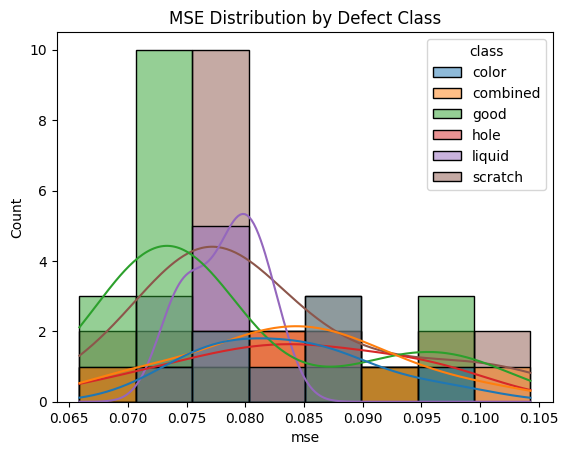

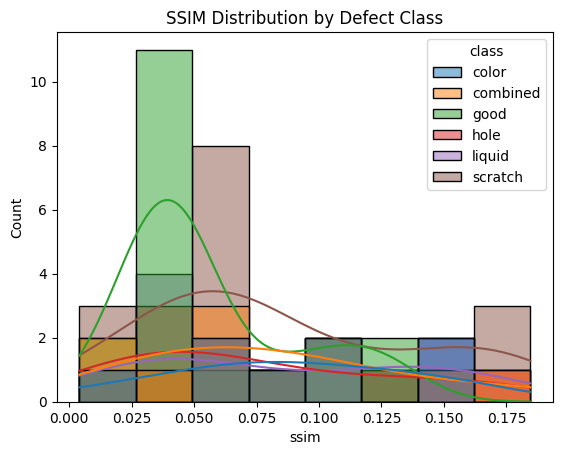

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_stats, x="mse", hue="class", kde=True)
plt.title("MSE Distribution by Defect Class")
plt.show()

sns.histplot(data=df_stats, x="ssim", hue="class", kde=True)
plt.title("SSIM Distribution by Defect Class")
plt.show()

In [16]:
df_stats["label"] = df_stats["class"].apply(lambda x: 0 if x == "good" else 1)

ROC AUC (MSE as score): 0.6719


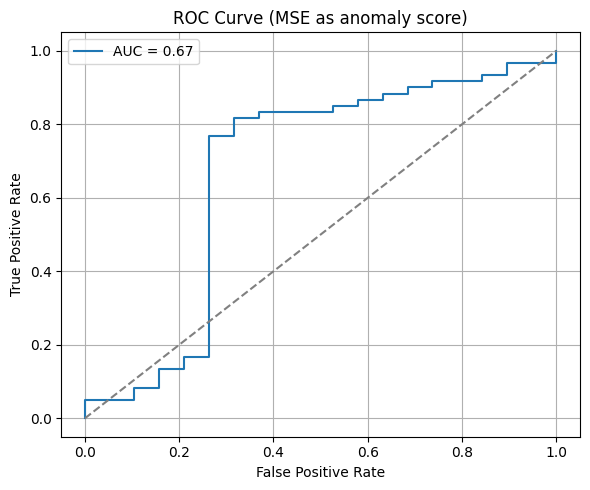

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# ROC AUC using MSE as score
# -----------------------------
y_true = df_stats["label"]
y_score = df_stats["mse"]  # Use "ssim" if preferred (inverted)

auc_score = roc_auc_score(y_true, y_score)
print(f"ROC AUC (MSE as score): {auc_score:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MSE as anomaly score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt

def evaluate_map_ganomaly(y_true, y_score):
    # y_true: list of 0 (normal) or 1 (defect)
    # y_score: corresponding anomaly scores

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    auc_score = auc(recall, precision)

    # Plot PR curve
    plt.plot(recall, precision, label=f"mAP (AP): {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Mean Average Precision (mAP/AP): {ap:.4f}")
    print(f"AUC under PR curve: {auc_score:.4f}")
    return ap

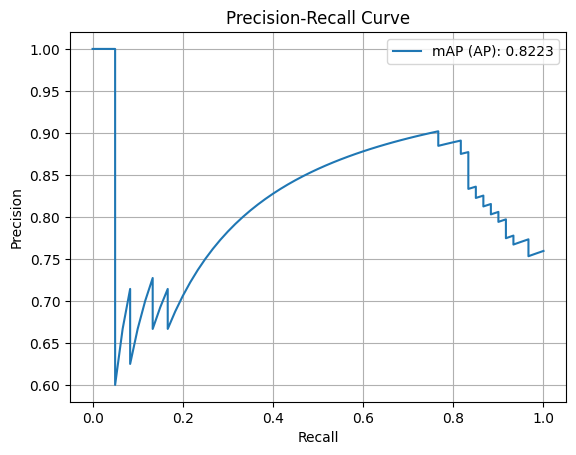

Mean Average Precision (mAP/AP): 0.8223
AUC under PR curve: 0.8178


0.8223258596189967

In [23]:
evaluate_map_ganomaly(y_true, y_score)